# Training the Equity Correlation Predictor Model

In this notebook we will train the equity correlation predictor model using features derived from the Neo4j graph database constructed in the previous notebooks. The goal is to predict potential correlations between stocks in future time windows based on historical data.

We will use a supervised machine learning approach, where the model is trained on labeled data indicating whether pairs of stocks were correlated in a given time window. The features used for training will include graph-based metrics (e.g., common neighbors, degree, Jaccard coefficient) as well as node attributes (e.g., sector, average transaction volumes). For this model, we will utilize the [XGBoost](https://xgboost.readthedocs.io/en/stable/) classifier due to its effectiveness in handling structured data and its ability to capture complex relationships. Many other classifiers could be used instead, such as Random Forests, Logistic Regression, or Neural Networks, depending on the specific requirements and characteristics of the dataset.

In [1]:
# Core libs
import logging
from neo4j import GraphDatabase
import pandas as pd

# Load env vars
from dotenv import load_dotenv
import os

# Set the logging level for the 'neo4j' module to ERROR
logging.getLogger("neo4j").setLevel(logging.ERROR)

load_dotenv()
# Neo4j connection details
URI = os.getenv("NEO4J_URI", "bolt://localhost:7687")
USER = os.getenv("NEO4J_USER", "neo4j")
PASSWORD = os.getenv("NEO4J_PASSWORD", "password")
DATABASE = os.getenv("NEO4J_DATABASE", "stocks")

driver = GraphDatabase.driver(URI, auth=(USER, PASSWORD))

def run_cypher(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a Cypher query and return a pandas DataFrame."""
    with driver.session(database=DATABASE) as session:
        result = session.run(query, params or {})
        return pd.DataFrame([r.data() for r in result])


As described in [the data loader](correlator.ipynb), the model uses historical stock data divided into time windows to construct correlation graphs. Each graph represents stocks as nodes and significant correlations as edges. The model is trained to predict the formation of edges in future time windows based on features extracted from the graph structure and node attributes. We load time windows from the Neo4j database to create our training and testing datasets.

In [2]:
# Get all windows with their start/end dates
df_windows = run_cypher("""
MATCH ()-[r:CO_MOVES_WITH]-()
RETURN r.window_id AS window_id,
       min(r.start) AS start,
       max(r.end)   AS end
ORDER BY start
""")

df_windows["start"] = pd.to_datetime(df_windows["start"].astype(str))
df_windows["end"]   = pd.to_datetime(df_windows["end"].astype(str))

df_windows[:5]


,window_id,start,end
0,W_20180102_20180328,2018-01-02,2018-03-28
1,W_20180105_20180403,2018-01-05,2018-04-03
2,W_20180110_20180406,2018-01-10,2018-04-06
3,W_20180116_20180411,2018-01-16,2018-04-11
4,W_20180119_20180416,2018-01-19,2018-04-16


In [3]:
# Sorted list of window_ids
window_ids = df_windows["window_id"].tolist()
window_ids[:5]


['W_20180102_20180328',
 'W_20180105_20180403',
 'W_20180110_20180406',
 'W_20180116_20180411',
 'W_20180119_20180416']

We need a few helpers to compute cosine similarity between vectors, and to extract edges present in a given time window.

In [4]:
from numpy.linalg import norm
import numpy as np

def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    """Cosine similarity between two vectors."""
    na = norm(a)
    nb = norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(np.dot(a, b) / (na * nb))


def get_edge_set(window_id: str) -> set:
    """
    Return set of undirected edges (u, v) for a given window_id.
    u < v (sorted) to make them canonical.
    """
    df_edges = run_cypher("""
    MATCH (s1:Stock)-[r:CO_MOVES_WITH {window_id: $window_id}]-(s2:Stock)
    WHERE elementId(s1) < elementId(s2)
    RETURN s1.ticker AS src, s2.ticker AS dst
    """, {"window_id": window_id})

    edge_set = set()
    for _, row in df_edges.iterrows():
        u, v = row["src"], row["dst"]
        pair = tuple(sorted((u, v)))
        edge_set.add(pair)
    return edge_set


We also need a method which computes embeddings for all Stock nodes in a given time window using the Node2Vec algorithm. By default we use a small embedding space (16 dimensions), but this can be adjusted as needed.

In [5]:
def node2vec_for_window(window_id: str, embedding_dim: int = 16) -> pd.DataFrame:
    """
    Project the graph for a given window_id into GDS, run Node2Vec,
    and return a DataFrame [ticker, embedding].
    """
    graph_name = f"lp_{window_id}"

    # Project graph for this window (Cypher projection)
    run_cypher("""
    MATCH (s1:Stock)-[r:CO_MOVES_WITH {window_id: $window_id}]-(s2:Stock)
    WITH gds.graph.project(
      $graph_name,
      s1,
      s2,
      {},                          // no relationship properties needed for unweighted Node2Vec
      {dropExisting: true}
    ) AS g
    RETURN g.graphName AS graph, g.nodeCount AS nodes, g.relationshipCount AS rels
    """, {
        "graph_name": graph_name,
        "window_id": window_id
    })

    # Unweighted Node2Vec
    df_emb = run_cypher("""
    CALL gds.node2vec.stream($graph_name, {
      embeddingDimension: $dim
    })
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).ticker AS ticker,
           embedding
    """, {"graph_name": graph_name, "dim": embedding_dim})

    # Drop the in-memory graph (safe to leave if memory ok)
    run_cypher("""
    CALL gds.graph.drop($graph_name, false) YIELD graphName
    """, {"graph_name": graph_name})

    return df_emb


In [6]:
test_win = window_ids[0]
df_emb_test = node2vec_for_window(test_win, embedding_dim=16)
df_emb_test.head()


,ticker,embedding
0,ABT,"[-0.520926296710968, 0.09462784975767136, -0.2..."
1,ACN,"[-0.2901398837566376, 0.0067220120690763, -0.1..."
2,ADSK,"[-0.5684593319892883, 0.20658276975154877, -0...."
3,AIZ,"[-0.43098777532577515, 0.08005575835704803, -0..."
4,AMP,"[-0.5597139596939087, 0.24475349485874176, -0...."


In addition we need to compute several graph-based features for pairs of stocks, such as common neighbors, and Jaccarc coefficient. These features help capture the structural relationships between stocks in the correlation graph, providing valuable information for the prediction model.

In [7]:
# GDS based graph feature extractor
def gds_features_for_window(window_id: str, embedding_dim: int = 16):
    """
    For a given window_id, project the Stock–CO_MOVES_WITH subgraph into GDS,
    and compute:
      - Node2Vec embeddings
      - Degree
      - Jaccard similarity for node pairs (via gds.nodeSimilarity)

    Returns:
      - emb_map:   {ticker -> np.array embedding}
      - deg_map:   {ticker -> degree}
      - sim_map:   {(u, v) -> {"jaccard": float}}
      - tickers:   sorted list of tickers in this graph
    """
    graph_name = f"lp_{window_id}"

    # Project graph for this window (Cypher projection, undirected)
    run_cypher("""
    MATCH (s1:Stock)-[r:CO_MOVES_WITH {window_id: $window_id}]-(s2:Stock)
    WITH gds.graph.project(
      $graph_name,
      s1,
      s2,
      {},                          // no rel props needed for these algos
      {dropExisting: true}
    ) AS g
    RETURN g.graphName AS graph, g.nodeCount AS nodes, g.relationshipCount AS rels
    """, {
        "graph_name": graph_name,
        "window_id": window_id
    })

    # Node2Vec embeddings
    df_emb = run_cypher("""
    CALL gds.node2vec.stream($graph_name, {
      embeddingDimension: $dim
    })
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).ticker AS ticker,
           embedding
    """, {"graph_name": graph_name, "dim": embedding_dim})

    if df_emb.empty:
        run_cypher("""
        CALL gds.graph.drop($graph_name, false)
        """, {"graph_name": graph_name})
        return {}, {}, {}, []

    emb_array = np.vstack(df_emb["embedding"].values)
    emb_cols = [f"e{i}" for i in range(emb_array.shape[1])]
    for i, col in enumerate(emb_cols):
        df_emb[col] = emb_array[:, i]

    emb_map = {
        row["ticker"]: row[emb_cols].values.astype(float)
        for _, row in df_emb.iterrows()
    }
    tickers = sorted(emb_map.keys())

    # Degree
    df_deg = run_cypher("""
    CALL gds.degree.stream($graph_name)
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).ticker AS ticker,
           score AS degree
    """, {"graph_name": graph_name})

    deg_map = {row["ticker"]: row["degree"] for _, row in df_deg.iterrows()}

    # Jaccard via nodeSimilarity
    df_sim = run_cypher("""
    CALL gds.nodeSimilarity.stream($graph_name, {
      similarityMetric: 'JACCARD'
    })
    YIELD node1, node2, similarity
    RETURN gds.util.asNode(node1).ticker AS u,
           gds.util.asNode(node2).ticker AS v,
           similarity AS jaccard
    """, {"graph_name": graph_name})

    sim_map = {}
    for _, row in df_sim.iterrows():
        u, v = row["u"], row["v"]
        key = (u, v) if u < v else (v, u)
        sim_map[key] = {
            "jaccard": float(row["jaccard"]),
        }

    # Drop the in-memory graph
    run_cypher("""
    CALL gds.graph.drop($graph_name, false)
    """, {"graph_name": graph_name})

    return emb_map, deg_map, sim_map, tickers

In [8]:
# Load stock metadata into a map for quick lookup
df_meta = run_cypher("""
MATCH (s:Stock)
RETURN s.ticker AS ticker, s.sector AS sector, s.industry AS industry
""")

meta_map = df_meta.set_index("ticker").to_dict(orient="index")

def meta_lookup(ticker):
    m = meta_map.get(ticker, {})
    return m.get("sector", None), m.get("industry", None)

The graph also stores a number of useful metrics which were computed during the construction of the correlation graph, such as volatility, volume and momentum, which can also be used as features for the prediction model.

In [9]:
# Get metrics for a window
def get_window_metrics(window_id: str) -> dict[str, dict]:
    """
    Return per-ticker metrics for a given window_id from StockWindow nodes.

    Output:
      {
        "AAPL": {
          "volatility_norm": ...,
          "momentum_norm": ...,
          "volume_norm": ...
        },
        ...
      }
    """
    df_m = run_cypher("""
    MATCH (s:Stock)-[:HAS_METRICS]-(w:StockWindow {window_id: $window_id})
    RETURN s.ticker          AS ticker,
           w.volatility_norm AS volatility_norm,
           w.momentum_norm   AS momentum_norm,
           w.volume_norm     AS volume_norm
    """, {"window_id": window_id})

    metrics_map = {}
    for _, row in df_m.iterrows():
        metrics_map[row["ticker"]] = {
            "volatility_norm": float(row["volatility_norm"]) if row["volatility_norm"] is not None else 0.0,
            "momentum_norm":   float(row["momentum_norm"])   if row["momentum_norm"]   is not None else 0.0,
            "volume_norm":     float(row["volume_norm"])     if row["volume_norm"]     is not None else 0.0,
        }
    return metrics_map

Finally we bring all these features together to create a comprehensive feature set for windows at `t-1`, `t` and `t+1` (what we are trying to predict).

In [10]:
from itertools import combinations

def build_lp_samples_for_triple(prev_window: str,
                                src_window: str,
                                dst_window: str,
                                embedding_dim: int = 16) -> pd.DataFrame:
    """
    Build link prediction samples for transition:
        (prev_window -> src_window -> dst_window)

    Graph features at t (src_window):
      - cos_sim, degree_u/v, jaccard, same_sector

    Temporal graph deltas vs t-1:
      - delta_cos_sim, delta_degree_u/v, delta_jaccard

    Numeric window metrics (normalized) at t:
      - volatility_norm_u/v, momentum_norm_u/v (used only via pairwise features)

    Numeric pairwise features:
      - vol_norm_diff, mom_norm_diff

    Numeric deltas vs t-1:
      - delta_vol_norm_u/v, delta_mom_norm_u/v
    """
    # Graph-based features at t (src_window)
    emb_t, deg_t, sim_t, tickers_t = gds_features_for_window(src_window, embedding_dim=embedding_dim)
    if not tickers_t:
        return pd.DataFrame(columns=[
            "prev_window", "src_window", "dst_window", "u", "v",
            "cos_sim", "degree_u", "degree_v", "jaccard", "same_sector",
            "delta_cos_sim", "delta_degree_u", "delta_degree_v", "delta_jaccard",
            "vol_norm_diff", "mom_norm_diff",
            "delta_vol_norm_u", "delta_vol_norm_v",
            "delta_mom_norm_u", "delta_mom_norm_v",
            "label",
        ])

    # Graph-based features at t-1 (prev_window)
    emb_prev, deg_prev, sim_prev, tickers_prev = gds_features_for_window(prev_window, embedding_dim=embedding_dim)
    tickers_prev_set = set(tickers_prev)

    # Numeric metrics at t and t-1 (normalized)
    metrics_t    = get_window_metrics(src_window)
    metrics_prev = get_window_metrics(prev_window)

    # Edge sets at t and t+1
    edges_src = get_edge_set(src_window)
    edges_dst = get_edge_set(dst_window)
    new_edges = edges_dst - edges_src   # strictly new in dst

    rows = []
    for u, v in combinations(sorted(tickers_t), 2):
        pair = (u, v) if u < v else (v, u)

        # Graph features at t
        emb_u_t = emb_t[u]
        emb_v_t = emb_t[v]
        cos_sim_t = cosine_sim(emb_u_t, emb_v_t)

        degree_u_t = deg_t.get(u, 0.0)
        degree_v_t = deg_t.get(v, 0.0)

        sim_info_t = sim_t.get(pair, {"jaccard": 0.0})
        jaccard_t = sim_info_t["jaccard"]

        mu = meta_map.get(u, {})
        mv = meta_map.get(v, {})
        same_sector = int(
            mu.get("sector") is not None
            and mv.get("sector") is not None
            and mu.get("sector") == mv.get("sector")
        )

        # Graph features at t-1
        if u in tickers_prev_set and v in tickers_prev_set:
            emb_u_prev = emb_prev.get(u)
            emb_v_prev = emb_prev.get(v)
            if emb_u_prev is not None and emb_v_prev is not None:
                cos_sim_prev = cosine_sim(emb_u_prev, emb_v_prev)
            else:
                cos_sim_prev = cos_sim_t
            degree_u_prev = deg_prev.get(u, degree_u_t)
            degree_v_prev = deg_prev.get(v, degree_v_t)
            sim_info_prev = sim_prev.get(pair, {"jaccard": jaccard_t})
            jaccard_prev = sim_info_prev["jaccard"]
        else:
            cos_sim_prev  = cos_sim_t
            degree_u_prev = degree_u_t
            degree_v_prev = degree_v_t
            jaccard_prev  = jaccard_t

        delta_cos_sim   = cos_sim_t   - cos_sim_prev
        delta_degree_u  = degree_u_t  - degree_u_prev
        delta_degree_v  = degree_v_t  - degree_v_prev
        delta_jaccard   = jaccard_t   - jaccard_prev

        # Normalized metrics at t
        m_u_t = metrics_t.get(u, {})
        m_v_t = metrics_t.get(v, {})

        voln_u_t = m_u_t.get("volatility_norm", 0.0)
        voln_v_t = m_v_t.get("volatility_norm", 0.0)
        momn_u_t = m_u_t.get("momentum_norm",   0.0)
        momn_v_t = m_v_t.get("momentum_norm",   0.0)
        volu_u_t = m_u_t.get("volume_norm", 0.0)
        volu_v_t = m_v_t.get("volume_norm", 0.0)

        vol_norm_diff = abs(voln_u_t - voln_v_t)
        mom_norm_diff = abs(momn_u_t - momn_v_t)
        volu_norm_diff = abs(volu_u_t - volu_v_t)

        # Normalized metrics at t-1
        m_u_prev = metrics_prev.get(u, {})
        m_v_prev = metrics_prev.get(v, {})

        voln_u_prev = m_u_prev.get("volatility_norm", voln_u_t)
        voln_v_prev = m_v_prev.get("volatility_norm", voln_v_t)
        momn_u_prev = m_u_prev.get("momentum_norm",   momn_u_t)
        momn_v_prev = m_v_prev.get("momentum_norm",   momn_v_t)
        volu_u_prev = m_u_prev.get("volume_norm", volu_u_t)
        volu_v_prev = m_v_prev.get("volume_norm", volu_v_t)

        delta_vol_norm_u = voln_u_t - voln_u_prev
        delta_vol_norm_v = voln_v_t - voln_v_prev
        delta_mom_norm_u = momn_u_t - momn_u_prev
        delta_mom_norm_v = momn_v_t - momn_v_prev
        delta_volu_norm_u = volu_u_t - volu_u_prev
        delta_volu_norm_v = volu_v_t - volu_v_prev

        # Label
        label = 1 if pair in new_edges else 0

        rows.append({
            "prev_window": prev_window,
            "src_window": src_window,
            "dst_window": dst_window,
            "u": u,
            "v": v,
            "cos_sim": cos_sim_t,
            "degree_u": degree_u_t,
            "degree_v": degree_v_t,
            "jaccard": jaccard_t,
            "same_sector": same_sector,
            "delta_cos_sim": delta_cos_sim,
            "delta_degree_u": delta_degree_u,
            "delta_degree_v": delta_degree_v,
            "delta_jaccard": delta_jaccard,
            "vol_norm_diff": vol_norm_diff,
            "mom_norm_diff": mom_norm_diff,
            "volu_norm_diff": volu_norm_diff,
            "delta_vol_norm_u": delta_vol_norm_u,
            "delta_vol_norm_v": delta_vol_norm_v,
            "delta_mom_norm_u": delta_mom_norm_u,
            "delta_mom_norm_v": delta_mom_norm_v,
            "delta_volu_norm_u": delta_volu_norm_u,
            "delta_volu_norm_v": delta_volu_norm_v,
            "label": label,
        })

    return pd.DataFrame(rows)

In [11]:
# Build (prev, src, dst) triples: (t-1, t, t+1)
triples = list(zip(window_ids[:-2], window_ids[1:-1], window_ids[2:]))
triples[:5]

[('W_20180102_20180328', 'W_20180105_20180403', 'W_20180110_20180406'),
 ('W_20180105_20180403', 'W_20180110_20180406', 'W_20180116_20180411'),
 ('W_20180110_20180406', 'W_20180116_20180411', 'W_20180119_20180416'),
 ('W_20180116_20180411', 'W_20180119_20180416', 'W_20180124_20180419'),
 ('W_20180119_20180416', 'W_20180124_20180419', 'W_20180129_20180424')]

Finally we can build the training and testing datasets.

In [12]:
from tqdm.auto import tqdm

# Use all but last triple for training, last triple for test
train_triples = triples[:-1]
test_triple   = triples[-1]

train_frames = []

for prev, src, dst in tqdm(train_triples, desc="Building training samples (with deltas)"):
    df_triple = build_lp_samples_for_triple(prev, src, dst, embedding_dim=16)
    if not df_triple.empty:
        train_frames.append(df_triple)

df_train_all = pd.concat(train_frames, ignore_index=True)

print("Train label distribution:")
df_train_all["label"].value_counts()

Building training samples (with deltas):   0%|          | 0/634 [00:00<?, ?it/s]

Train label distribution:


label
0    2121261
1      39725
Name: count, dtype: int64

In [13]:
# Build test samples from the final transition triple
prev_test, src_test, dst_test = test_triple
print(f"Test triple: {prev_test} -> {src_test} -> {dst_test}")

df_test = build_lp_samples_for_triple(prev_test, src_test, dst_test, embedding_dim=16)

print("Test label distribution:")
df_test["label"].value_counts()

Test triple: W_20250729_20251021 -> W_20250801_20251024 -> W_20250806_20251029
Test label distribution:
Test label distribution:


label
0    2669
1      32
Name: count, dtype: int64

In [14]:
df_test.sample(5)

,prev_window,src_window,dst_window,u,v,cos_sim,degree_u,degree_v,jaccard,same_sector,...,vol_norm_diff,mom_norm_diff,volu_norm_diff,delta_vol_norm_u,delta_vol_norm_v,delta_mom_norm_u,delta_mom_norm_v,delta_volu_norm_u,delta_volu_norm_v,label
532,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,BR,PGR,0.232986,3.0,2.0,0.0,0,...,0.127265,0.380119,1.536334,-0.010306,0.010902,0.166452,-0.019077,-0.038077,-0.012136,0
1961,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,MET,MMC,0.666402,4.0,3.0,0.0,1,...,0.070036,1.118768,0.291127,-0.169424,-0.003966,0.414507,0.165982,-0.034818,-0.023599,0
1099,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,DOW,WAB,0.634357,8.0,5.0,0.0,0,...,2.110883,0.757126,2.606943,0.398911,-0.003814,2.670325,0.262608,0.010949,-0.058946,0
2653,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,TRGP,WDC,0.368556,4.0,1.0,0.0,0,...,1.583777,6.970869,1.734332,0.040420,-0.264567,0.557838,-0.825356,0.001193,-0.046121,0
2372,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,NWS,WDAY,0.352806,1.0,6.0,0.0,0,...,0.562443,1.732272,0.970745,0.013891,-0.110978,0.204837,0.607408,-0.003757,-0.018951,0


And we can now run the XGBoost classifier to train the model and evaluate its performance on the test dataset.

In [15]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score

feature_cols = [
    # graph, static
    "cos_sim",
    "degree_u",
    "degree_v",
    "jaccard",
    # graph deltas
    "delta_cos_sim",
    "delta_degree_u",
    "delta_degree_v",
    "delta_jaccard",
    # numeric normalized pairwise
    "vol_norm_diff"
]

X_train = df_train_all[feature_cols]
y_train = df_train_all["label"]

X_test = df_test[feature_cols]
y_test = df_test["label"]

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test, label=y_test)

pos = y_train.sum()
neg = len(y_train) - pos
scale = neg / pos if pos > 0 else 1.0

params = {
    "objective": "rank:pairwise",
    "eval_metric": "aucpr",
    "eta": 0.05,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42,
}

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=300,
    evals=[(dtrain, "train"), (dtest, "test")],
    verbose_eval=False
)

y_proba = bst.predict(dtest)

roc = roc_auc_score(y_test, y_proba)
ap  = average_precision_score(y_test, y_proba)

roc, ap


(0.7206526320719371, 0.07900138795357849)

In [16]:
# Calculate the fraction of positives in the test set
baseline = y_test.sum() / len(y_test)
print(f"Baseline (Random Chance): {baseline:.4f}")
print(f"Model AP: {ap:.4f}")
print(f"Lift: {ap / baseline:.2f}x")

Baseline (Random Chance): 0.0118
Model AP: 0.0790
Lift: 6.67x


In [17]:
# Evaluate Precision@K
df_eval = df_test.copy()
df_eval["proba"] = y_proba

for K in [5, 10, 20]:
    prec_k = (
        df_eval.sort_values("proba", ascending=False)
               .head(K)["label"]
               .mean()
    )
    print(f"Precision@{K}: {prec_k:.3f}")

Precision@5: 0.200
Precision@10: 0.200
Precision@20: 0.150


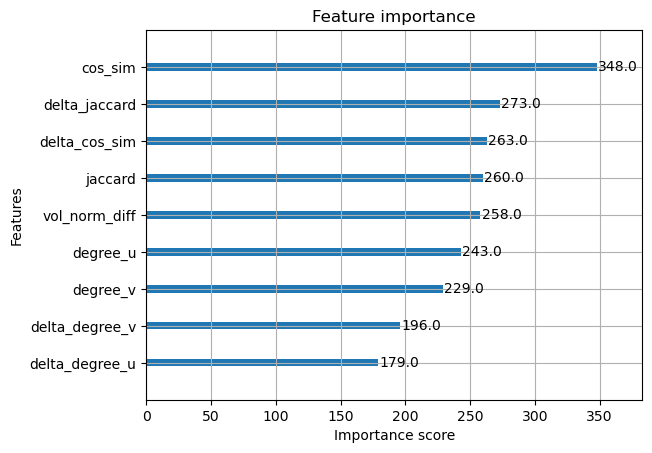

In [18]:
import matplotlib.pyplot as plt

xgb.plot_importance(bst)
plt.show()

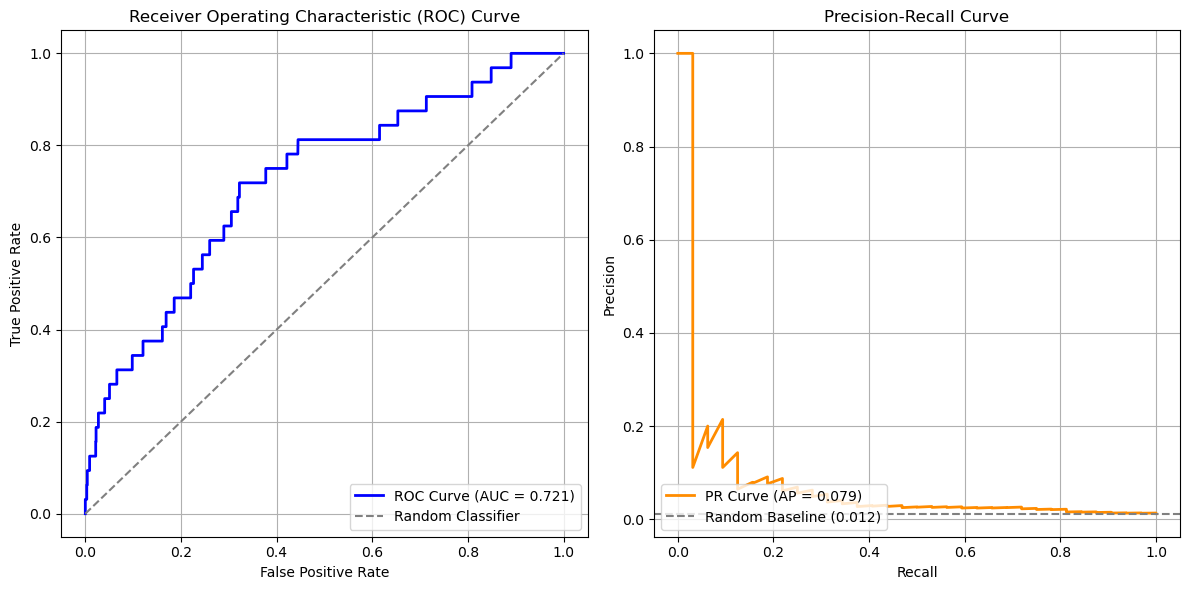

In [19]:
from sklearn.metrics import roc_curve, precision_recall_curve

# Calculate the ROC curve points (False Positive Rate, True Positive Rate)
fpr, tpr, _ = roc_curve(y_test, y_proba)

# Calculate the Random Classifier Baseline
random_baseline = [0, 1]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

### ROC Plot (Left Subplot)
axes[0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc:.3f})')
axes[0].plot(random_baseline, random_baseline, linestyle='--', color='gray', label='Random Classifier')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[0].legend(loc="lower right")
axes[0].grid(True)

# Calculate the PR curve points (Precision, Recall)
precision, recall, _ = precision_recall_curve(y_test, y_proba)

# Calculate the Baseline Precision (fraction of positive cases)
baseline = y_test.sum() / len(y_test)

axes[1].plot(recall, precision, color='darkorange', lw=2, label=f'PR Curve (AP = {ap:.3f})')
axes[1].axhline(y=baseline, color='gray', linestyle='--', label=f'Random Baseline ({baseline:.3f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc="lower left")
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [20]:
# Recompute edge sets for test source and target
edges_src_test = get_edge_set(src_test)
edges_dst_test = get_edge_set(dst_test)
new_edges_test = edges_dst_test - edges_src_test

df_test = df_test.copy()
df_test["proba"] = y_proba

# Candidate edges: not in src_test (i.e. could potentially be "new")
df_candidates = df_test[[ (u, v) not in edges_src_test for u, v in df_test[["u", "v"]].to_numpy() ]]

df_top = (
    df_candidates
    .sort_values("proba", ascending=False)
    .head(25)
)

df_top


,prev_window,src_window,dst_window,u,v,cos_sim,degree_u,degree_v,jaccard,same_sector,...,mom_norm_diff,volu_norm_diff,delta_vol_norm_u,delta_vol_norm_v,delta_mom_norm_u,delta_mom_norm_v,delta_volu_norm_u,delta_volu_norm_v,label,proba
1988,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,MET,TROW,0.845423,4.0,6.0,0.428571,1,...,0.544500,0.812798,-0.169424,-0.034154,0.414507,0.108918,-0.034818,-0.037903,1,0.550463
451,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,BLK,MET,0.892572,5.0,4.0,0.500000,1,...,0.205676,1.762507,-0.012506,-0.169424,0.306858,0.414507,0.007600,-0.034818,0,-1.256466
2319,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,NUE,WDAY,0.885444,16.0,6.0,0.157895,0,...,0.860164,0.812951,-0.009212,-0.110978,0.010643,0.607408,-0.062332,-0.018951,0,-1.348680
1703,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,J,URI,0.525837,6.0,7.0,0.444444,1,...,0.793143,0.577423,0.128076,0.363759,-0.156334,-0.792327,0.048361,0.029795,1,-1.372167
257,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,AMP,NUE,0.806171,8.0,16.0,0.142857,0,...,0.417727,1.114668,-0.056224,-0.009212,0.391971,0.010643,-0.006471,-0.062332,0,-1.422462
1544,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,HAL,NUE,0.814485,8.0,16.0,0.200000,0,...,2.136658,2.193776,0.052989,-0.009212,1.192701,0.010643,0.003167,-0.062332,0,-1.454145
1667,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,J,KEYS,0.643113,6.0,12.0,0.384615,0,...,0.741652,0.149786,0.128076,-0.044551,-0.156334,0.614617,0.048361,0.003056,1,-1.474393
1002,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,DHI,J,0.643557,5.0,6.0,0.571429,0,...,0.901239,1.403572,-0.168773,0.128076,-0.298783,-0.156334,-0.016721,0.048361,0,-1.627887
2313,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,NUE,TROW,0.832771,16.0,6.0,0.157895,0,...,0.042352,0.007694,-0.009212,-0.034154,0.010643,0.108918,-0.062332,-0.037903,0,-1.630488
754,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,CPT,DVA,0.993081,1.0,1.0,1.000000,0,...,0.461149,0.144582,-0.136257,-0.037673,0.830717,0.590510,-0.004055,0.001345,0,-1.653183


In [21]:
df_top[["u_sector", "u_industry"]] = df_top["u"].apply(lambda t: pd.Series(meta_lookup(t)))
df_top[["v_sector", "v_industry"]] = df_top["v"].apply(lambda t: pd.Series(meta_lookup(t)))

df_top

,prev_window,src_window,dst_window,u,v,cos_sim,degree_u,degree_v,jaccard,same_sector,...,delta_mom_norm_u,delta_mom_norm_v,delta_volu_norm_u,delta_volu_norm_v,label,proba,u_sector,u_industry,v_sector,v_industry
1988,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,MET,TROW,0.845423,4.0,6.0,0.428571,1,...,0.414507,0.108918,-0.034818,-0.037903,1,0.550463,Financial Services,Insurance-Life,Financial Services,Asset Management
451,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,BLK,MET,0.892572,5.0,4.0,0.500000,1,...,0.306858,0.414507,0.007600,-0.034818,0,-1.256466,Financial Services,Asset Management,Financial Services,Insurance-Life
2319,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,NUE,WDAY,0.885444,16.0,6.0,0.157895,0,...,0.010643,0.607408,-0.062332,-0.018951,0,-1.348680,Basic Materials,Steel,Technology,Software-Application
1703,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,J,URI,0.525837,6.0,7.0,0.444444,1,...,-0.156334,-0.792327,0.048361,0.029795,1,-1.372167,Industrials,Engineering & Construction,Industrials,Rental & Leasing Services
257,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,AMP,NUE,0.806171,8.0,16.0,0.142857,0,...,0.391971,0.010643,-0.006471,-0.062332,0,-1.422462,Financial Services,Asset Management,Basic Materials,Steel
1544,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,HAL,NUE,0.814485,8.0,16.0,0.200000,0,...,1.192701,0.010643,0.003167,-0.062332,0,-1.454145,Energy,Oil & Gas Equipment & Services,Basic Materials,Steel
1667,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,J,KEYS,0.643113,6.0,12.0,0.384615,0,...,-0.156334,0.614617,0.048361,0.003056,1,-1.474393,Industrials,Engineering & Construction,Technology,Scientific & Technical Instruments
1002,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,DHI,J,0.643557,5.0,6.0,0.571429,0,...,-0.298783,-0.156334,-0.016721,0.048361,0,-1.627887,Consumer Cyclical,Residential Construction,Industrials,Engineering & Construction
2313,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,NUE,TROW,0.832771,16.0,6.0,0.157895,0,...,0.010643,0.108918,-0.062332,-0.037903,0,-1.630488,Basic Materials,Steel,Financial Services,Asset Management
754,W_20250729_20251021,W_20250801_20251024,W_20250806_20251029,CPT,DVA,0.993081,1.0,1.0,1.000000,0,...,0.830717,0.590510,-0.004055,0.001345,0,-1.653183,Real Estate,REIT-Residential,Healthcare,Medical Care Facilities
